In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import random
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats
from scipy.spatial.distance import pdist

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset
import torch.cuda as cutorch

#Import User defined classes
from data_helpers import DataHelper
from models import SimpleNet, SiameseNet
from siamese_dataset import SiameseTriplets
from train_test_helpers import accuracy,train_model,evaluate_model,evaluate_model_paper,test_model,plot_learning_curves

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [15]:
df = pd.read_csv('Data/text.txt', sep = " ", header = None)
df.columns = ["keyword","word"]

In [16]:
keyword_to_word = {}
for row in df.itertuples():
    keyword_to_word[row.keyword] = row.word

In [24]:
len(Counter(keyword_to_word.values()).keys())

11976

In [2]:
num_examples = np.Inf
frequency_bounds = (5,np.Inf)
train_sm_dataset = SiameseTriplets(num_examples = num_examples, split_set = "train", frequency_bounds = frequency_bounds)
val_sm_dataset = SiameseTriplets(num_examples = num_examples, split_set = "val", frequency_bounds = frequency_bounds)
test_sm_dataset = SiameseTriplets(num_examples = num_examples, split_set = "test", frequency_bounds = frequency_bounds)

Length before filtering on char length 317927
Length after filtering on char length 173657
Length before filtering on frequency_bounds 173657
Length after filtering on frequency_bounds 162522
Finished Loading the Data, 162522 examples
Number of Unique words  3280
[1968, 656, 656]
For trainset number of unique words are 1968
torch.Size([19680, 3, 40, 100])
Length before filtering on char length 317927
Length after filtering on char length 173657
Length before filtering on frequency_bounds 173657
Length after filtering on frequency_bounds 162522
Finished Loading the Data, 162522 examples
Number of Unique words  3280
[1968, 656, 656]
For valset number of unique words are 656
torch.Size([6560, 3, 40, 100])
Length before filtering on char length 317927
Length after filtering on char length 173657
Length before filtering on frequency_bounds 173657
Length after filtering on frequency_bounds 162522
Finished Loading the Data, 162522 examples
Number of Unique words  3280
[1968, 656, 656]
For tes

In [3]:
train_dl = torch.utils.data.DataLoader(train_sm_dataset, shuffle = True, batch_size = 64, pin_memory = True)
val_dl = torch.utils.data.DataLoader(val_sm_dataset, shuffle = True, batch_size = 64, pin_memory = True)
test_dl = torch.utils.data.DataLoader(test_sm_dataset, shuffle = True, batch_size = 64, pin_memory = True)

In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv1 = nn.Conv1d(40,96,(10))
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(96, 96, (8))
        #self.fc1 = nn.Linear(1728, 1024)
        self.fc1 = nn.Linear(672, 1024)
    
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = self.fc1(x)
        
        return x
    
    def give_embeddings(self,x,dev):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        return x.cpu().detach().numpy() if dev.type == 'cuda' else x.detach().numpy()

In [8]:
def cos_distance(cos,x_1,x_2):
    return (1- cos(x_1,x_2))/2

In [9]:
def cos_hinge_loss(word_embedding,same_word_embedding,diff_word_embedding,cos):
    m = 0.15
    lower_bound = torch.tensor(0.0).to(dev, non_blocking = True)
    a = torch.max(lower_bound,m + cos_distance(cos, word_embedding, same_word_embedding) - cos_distance(cos, word_embedding, diff_word_embedding))
    return torch.mean(a)

In [16]:
dims = [1024,2048,4096]

for dim in dims:
    net = SiameseNet(dim)
    net = net.float()
    net.to(dev)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    num_epochs = 100
    verbose = True
    model_save_path = "./Models/best_siamese_%d.pth"%(dim)
    best_val_loss = np.Inf
    
    for epoch in range(0,num_epochs):
        if verbose:
                print('epoch %d '%(epoch))

        train_loss = 0
        net.train()
        for batch_idx, (train_data,train_labels) in enumerate(train_dl):

            #print(train_data.shape)
            #Move to GPU
            optimizer.zero_grad()
            train_data = train_data.to(dev, non_blocking=True)
            word = train_data[:,0,:]
            same_word = train_data[:,1,:]
            diff_word = train_data[:,2,:]

            word_embedding = net(word)
            same_word_embedding = net(same_word)
            diff_word_embedding = net(diff_word)

            loss = cos_hinge_loss(word_embedding,same_word_embedding,diff_word_embedding, cos)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        net.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (val_data,val_labels) in enumerate(val_dl):

                val_data = val_data.to(dev, non_blocking=True)
                word = val_data[:,0,:]
                same_word = val_data[:,1,:]
                diff_word = val_data[:,2,:]

                word_embedding = net(word)
                same_word_embedding = net(same_word)
                diff_word_embedding = net(diff_word)

                val_loss += cos_hinge_loss(word_embedding,same_word_embedding,diff_word_embedding, cos)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print("Best val loss %.3f Saving Model..."%(val_loss/len(val_dl)))
                torch.save(net.state_dict(),model_save_path)


        if verbose:
            print("train loss: %.3f"%(train_loss/len(train_dl)))
            print("val loss: %.3f"%(val_loss/len(val_dl)))
    
    
    
    
    
    

epoch 0 
Best val loss 0.082 Saving Model...
train loss: 0.097
val loss: 0.082
epoch 1 
Best val loss 0.074 Saving Model...
train loss: 0.072
val loss: 0.074
epoch 2 
Best val loss 0.071 Saving Model...
train loss: 0.066
val loss: 0.071
epoch 3 
Best val loss 0.068 Saving Model...
train loss: 0.062
val loss: 0.068
epoch 4 
Best val loss 0.067 Saving Model...
train loss: 0.060
val loss: 0.067
epoch 5 
Best val loss 0.066 Saving Model...
train loss: 0.058
val loss: 0.066
epoch 6 
Best val loss 0.065 Saving Model...
train loss: 0.056
val loss: 0.065
epoch 7 
Best val loss 0.064 Saving Model...
train loss: 0.055
val loss: 0.064
epoch 8 
Best val loss 0.063 Saving Model...
train loss: 0.054
val loss: 0.063
epoch 9 
Best val loss 0.062 Saving Model...
train loss: 0.052
val loss: 0.062
epoch 10 
Best val loss 0.062 Saving Model...
train loss: 0.051
val loss: 0.062
epoch 11 
Best val loss 0.061 Saving Model...
train loss: 0.050
val loss: 0.061
epoch 12 
Best val loss 0.060 Saving Model...
trai

train loss: 0.044
val loss: 0.059
epoch 26 
Best val loss 0.058 Saving Model...
train loss: 0.044
val loss: 0.058
epoch 27 
Best val loss 0.058 Saving Model...
train loss: 0.043
val loss: 0.058
epoch 28 
Best val loss 0.058 Saving Model...
train loss: 0.043
val loss: 0.058
epoch 29 
Best val loss 0.058 Saving Model...
train loss: 0.042
val loss: 0.058
epoch 30 
Best val loss 0.058 Saving Model...
train loss: 0.042
val loss: 0.058
epoch 31 
Best val loss 0.058 Saving Model...
train loss: 0.041
val loss: 0.058
epoch 32 
Best val loss 0.057 Saving Model...
train loss: 0.041
val loss: 0.057
epoch 33 
train loss: 0.040
val loss: 0.057
epoch 34 
Best val loss 0.057 Saving Model...
train loss: 0.040
val loss: 0.057
epoch 35 
Best val loss 0.057 Saving Model...
train loss: 0.039
val loss: 0.057
epoch 36 
train loss: 0.039
val loss: 0.057
epoch 37 
Best val loss 0.057 Saving Model...
train loss: 0.038
val loss: 0.057
epoch 38 
Best val loss 0.057 Saving Model...
train loss: 0.038
val loss: 0.05

train loss: 0.034
val loss: 0.060
epoch 56 
train loss: 0.033
val loss: 0.060
epoch 57 
train loss: 0.033
val loss: 0.059
epoch 58 
Best val loss 0.059 Saving Model...
train loss: 0.033
val loss: 0.059
epoch 59 
train loss: 0.032
val loss: 0.059
epoch 60 
Best val loss 0.059 Saving Model...
train loss: 0.032
val loss: 0.059
epoch 61 
Best val loss 0.059 Saving Model...
train loss: 0.031
val loss: 0.059
epoch 62 
train loss: 0.031
val loss: 0.059
epoch 63 
train loss: 0.031
val loss: 0.060
epoch 64 
train loss: 0.030
val loss: 0.059
epoch 65 
train loss: 0.030
val loss: 0.059
epoch 66 
train loss: 0.029
val loss: 0.060
epoch 67 
train loss: 0.029
val loss: 0.059
epoch 68 
train loss: 0.029
val loss: 0.059
epoch 69 
train loss: 0.028
val loss: 0.059
epoch 70 
train loss: 0.028
val loss: 0.059
epoch 71 
train loss: 0.028
val loss: 0.059
epoch 72 
train loss: 0.027
val loss: 0.059
epoch 73 
train loss: 0.027
val loss: 0.060
epoch 74 
train loss: 0.027
val loss: 0.059
epoch 75 
train loss: 

In [8]:
net = SiameseNet()
net = net.float()
net.to(dev)

SiameseNet(
  (conv1): Conv1d(40, 96, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(96, 96, kernel_size=(8,), stride=(1,))
  (fc1): Linear(in_features=672, out_features=1024, bias=True)
)

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
num_epochs = 100
verbose = True
model_save_path = "./Models/best_siamese.pth"
best_val_loss = np.Inf

In [14]:


for epoch in range(0,num_epochs):
    if verbose:
            print('epoch %d '%(epoch))

    train_loss = 0
    net.train()
    for batch_idx, (train_data,train_labels) in enumerate(train_dl):

        #print(train_data.shape)
        #Move to GPU
        optimizer.zero_grad()
        train_data = train_data.to(dev, non_blocking=True)
        word = train_data[:,0,:]
        same_word = train_data[:,1,:]
        diff_word = train_data[:,2,:]

        word_embedding = net(word)
        same_word_embedding = net(same_word)
        diff_word_embedding = net(diff_word)

        loss = cos_hinge_loss(word_embedding,same_word_embedding,diff_word_embedding, cos)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        
    net.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, (val_data,val_labels) in enumerate(val_dl):

            val_data = val_data.to(dev, non_blocking=True)
            word = val_data[:,0,:]
            same_word = val_data[:,1,:]
            diff_word = val_data[:,2,:]

            word_embedding = net(word)
            same_word_embedding = net(same_word)
            diff_word_embedding = net(diff_word)

            val_loss += cos_hinge_loss(word_embedding,same_word_embedding,diff_word_embedding, cos)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("Best val loss %.3f Saving Model..."%(val_loss/len(val_dl)))
            torch.save(net.state_dict(),model_save_path)
        
        
    if verbose:
        print("train loss: %.3f"%(train_loss/len(train_dl)))
        print("val loss: %.3f"%(val_loss/len(val_dl)))
    
    #show_cuda_memory()
    

epoch 0 
Best val loss 0.079 Saving Model...
train loss: 0.097
val loss: 0.079
epoch 1 
Best val loss 0.072 Saving Model...
train loss: 0.073
val loss: 0.072
epoch 2 
Best val loss 0.068 Saving Model...
train loss: 0.067
val loss: 0.068
epoch 3 
Best val loss 0.066 Saving Model...
train loss: 0.064
val loss: 0.066
epoch 4 
Best val loss 0.065 Saving Model...
train loss: 0.061
val loss: 0.065
epoch 5 
Best val loss 0.063 Saving Model...
train loss: 0.059
val loss: 0.063
epoch 6 
Best val loss 0.062 Saving Model...
train loss: 0.058
val loss: 0.062
epoch 7 
Best val loss 0.061 Saving Model...
train loss: 0.056
val loss: 0.061
epoch 8 
Best val loss 0.060 Saving Model...
train loss: 0.055
val loss: 0.060
epoch 9 
Best val loss 0.060 Saving Model...
train loss: 0.054
val loss: 0.060
epoch 10 
Best val loss 0.059 Saving Model...
train loss: 0.053
val loss: 0.059
epoch 11 
Best val loss 0.059 Saving Model...
train loss: 0.052
val loss: 0.059
epoch 12 
Best val loss 0.058 Saving Model...
trai

KeyboardInterrupt: 

In [15]:
dims = [128,256,512]

for dim in dims:
    print("Dimension in %d"%(dim))
    net = SiameseNet(dim)
    net = net.float()
    net.to(dev)
    model_save_path = "./Models/best_siamese_%d.pth"%(dim)
    net.load_state_dict(torch.load(model_save_path))
    test_siamese(net,test_dl, dev)
    evaluate_model(net,test_dl,dev)
    

Dimension in 128
Test Loss is 0.057
The number of positive examples 72820 and negative examples 47863916
Average Precision is 0.129469
Dimension in 256
Test Loss is 0.055
The number of positive examples 73072 and negative examples 47863664
Average Precision is 0.140832
Dimension in 512
Test Loss is 0.052
The number of positive examples 73257 and negative examples 47863479
Average Precision is 0.144119


In [17]:
dims = [1024,2048,4096]

for dim in dims:
    print("Dimension in %d"%(dim))
    net = SiameseNet(dim)
    net = net.float()
    net.to(dev)
    model_save_path = "./Models/best_siamese_%d.pth"%(dim)
    net.load_state_dict(torch.load(model_save_path))
    test_siamese(net,test_dl, dev)
    evaluate_model(net,test_dl,dev)
    

Dimension in 1024
Test Loss is 0.053
The number of positive examples 73500 and negative examples 47863236
Average Precision is 0.140264
Dimension in 2048
Test Loss is 0.054
The number of positive examples 73228 and negative examples 47863508
Average Precision is 0.139699
Dimension in 4096
Test Loss is 0.057
The number of positive examples 73283 and negative examples 47863453
Average Precision is 0.134162


In [ ]:
print("bla")

In [29]:
del train_dl,train_sm_dataset,val_dl,val_sm_dataset

In [13]:
#Load the best model
net.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [12]:
def test_siamese(net,test_dl, dev):
    test_loss = 0
    net.eval()
    with torch.no_grad():
        for i,(test_data,test_labels) in enumerate(test_dl):

            #print(i)

            #show_cuda_memory()
            #if dev.type == 'cuda' and not test_data.is_cuda:
            #    test_data = test_data.to(dev, non_blocking=True)

            word = test_data[:,0,:].to(dev)
            same_word = test_data[:,1,:].to(dev)
            diff_word = test_data[:,2,:].to(dev)

            word_embedding = net(word)
            same_word_embedding = net(same_word)
            diff_word_embedding = net(diff_word)

            test_data.to('cpu')

            test_loss += cos_hinge_loss(word_embedding,same_word_embedding,diff_word_embedding, cos)
            #show_cuda_memory()
        print("Test Loss is %.3f"%(test_loss/len(test_dl)))

    
    

In [19]:
test_siamese(net,test_dl, dev)

Test Loss is 0.052


In [13]:
def evaluate_siamese_model(net,test_dl, dev):
    
    embeddings = None
    labels = None
    
    with torch.no_grad():
        for i, (test_data,test_labels) in enumerate(test_dl):
            #If device is GPU move features to GPU
            if dev.type == 'cuda' and not test_data.is_cuda:
                test_data = test_data.to(dev, non_blocking=True)

            word = test_data[:,0,:]
            same_word = test_data[:,1,:]
            diff_word = test_data[:,2,:]

            word_embedding = net(word).cpu().detach().numpy()
            same_word_embedding = net(same_word).cpu().detach().numpy()
            diff_word_embedding = net(diff_word).cpu().detach().numpy()

            word_labels = test_labels[:,0]
            same_word_labels = test_labels[:,0]
            diff_word_labels = test_labels[:,1]

            #Add to the main embeddings
            if embeddings is not None:
                embeddings = np.vstack((embeddings,word_embedding,same_word_embedding,diff_word_embedding))
                labels = np.concatenate((labels,word_labels,same_word_labels,diff_word_labels),axis=0)
            else:
                embeddings = np.vstack((word_embedding,same_word_embedding,diff_word_embedding))
                labels = np.concatenate((word_labels,same_word_labels,diff_word_labels),axis=0)
            
            if i==50:
                break


    
    #Calculate pairwise cosine distance
    distances = pairwise_distances(embeddings, metric='cosine')
    #Calculate pairwise cosine similarity
    similarity = pairwise_kernels(embeddings, metric = 'cosine')
    
    
    
    #Create labels of whether the words are same or not
    if torch.is_tensor(labels):
        labels = labels.detach().numpy()
        
    eval_labels = (labels[:,None]==labels).astype(float)
    
    
    
    #Remove the diagonal elements (word pairs with themselves)
    mask = np.array(np.tril(np.ones((similarity.shape[0],similarity.shape[0]), dtype= int),-1),dtype = bool)
    similarity = similarity[mask]
    distances = distances[mask]
    eval_labels = eval_labels[mask]
        
    #flatten the pairwise arrays
    distances = np.ravel(distances)
    similarity = np.ravel(similarity)
    #Flatten the labels
    eval_labels = np.ravel(eval_labels)
    
    num_positive = sum(eval_labels==1)
    num_negative = eval_labels.shape[0]-num_positive
    print('The number of positive examples %d and negative examples %d'%(num_positive,num_negative))
    #Calculate the Average Precision
    avg_p = average_precision_score(eval_labels,similarity)
    #avg_p = average_precision_score(eval_labels,2-distances)
    #avg_p = average_precision_score(eval_labels,2-distances)
    print('Average Precision is %f'%(avg_p))
    return avg_p

In [17]:
evaluate_siamese_model(net,test_dl,dev)

The number of positive examples 72941 and negative examples 47863795
Average Precision is 0.138004


0.1380038415935497

End Of Training Cells

In [15]:
from sfba4.utils import alignSequences
from itertools import product
from big_phoney import BigPhoney

Using TensorFlow backend.


In [20]:
phoney = BigPhoney()

In [16]:
words = set([num_to_word[labels[i].item()] for i in range(labels.shape[0])])
train_words = set([num_to_word[y_train[i].item()] for i in range(y_train.shape[0])])
val_words = set([num_to_word[y_val[i].item()] for i in range(y_val.shape[0])])
test_words = set([num_to_word[y_test[i].item()] for i in range(y_test.shape[0])])

In [17]:
print(len(test_words))

3948


In [18]:
word_pairs = list(product(list(words),list(words)))

In [19]:
print(len(word_pairs))

67881121


In [20]:
word_pairs = [tuple(sorted(word_pair)) for word_pair in word_pairs if word_pair[0]!=word_pair[1]]

In [21]:
word_pairs = set(word_pairs)
print(len(word_pairs))

33936441


In [22]:
print(len(word_pairs))

33936441


In [57]:
print(len(word_pairs))

33936441


In [ ]:
homophone_pairs = []
for word_pair in word_pairs:
    #Phonemize the words and align them
    aligned_seq1, aligned_seq2, eDistance = alignSequences.align(phoney.phonize(word_pair[0]), phoney.phonize(word_pair[1]))
    if eDistance == 0:
        homophone_pairs.append(word_pair)
print(len(homophone_pairs))   

In [ ]:
print(len(homophone_pairs))

In [30]:
aligned_seq1, aligned_seq2, eDistance = alignSequences.align(word1[0], word2[0])

In [32]:
print(aligned_seq1,aligned_seq2,eDistance)

diary diary 0


In [23]:
words_df = pd.DataFrame({"word1": list(word1), "word2": list(word2)})

In [24]:
words_df.to_csv('words.txt', index = False, header = False)
#words_df.to_csv('words1.txt', index = False, header = False)

In [22]:
from sfba4.utils import *
import sys

In [27]:
! python phonemicExpansion -iFile words1.txt -wid 0 -oFile result.txt -cid 0 -compIndexPhonemes 1 -d ","

python: can't open file 'phonemicExpansion': [Errno 2] No such file or directory


In [19]:
homophone_list = [("air","heir"),("aisle","isle")]

In [20]:
homophone_list = []
with open('homophone_list.txt') as fp:
    lines = fp.readlines()
    for line in lines:
        words = line.strip(" \n").split(",")
        words = [word.strip(" ") for word in words]
        homophone_list.append((words[0],words[1]))
        

In [21]:
print(homophone_list)

[('accessary', 'accessory'), ('ad', 'add'), ('ail', 'ale'), ('air', 'heir'), ('aisle', "I'll"), ('all', 'awl'), ('allowed', 'aloud'), ('alms', 'arms'), ('altar', 'alter'), ('arc', 'ark'), ("aren't", 'aunt'), ('ate', 'eight'), ('auger', 'augur'), ('auk', 'orc'), ('aural', 'oral'), ('away', 'aweigh'), ('awe', 'oar'), ('axel', 'axle'), ('aye', 'eye'), ('bail', 'bale'), ('bait', 'bate'), ('baize', 'bays'), ('bald', 'bawled'), ('ball', 'bawl'), ('band', 'banned'), ('bard', 'barred'), ('bare', 'bear'), ('bark', 'barque'), ('baron', 'barren'), ('base', 'bass'), ('bay', 'bey'), ('bazaar', 'bizarre'), ('be', 'bee'), ('beach', 'beech'), ('bean', 'been'), ('beat', 'beet'), ('beau', 'bow'), ('beer', 'bier'), ('bel', 'bell'), ('berry', 'bury'), ('berth', 'birth'), ('bight', 'bite'), ('billed', 'build'), ('bitten', 'bittern'), ('blew', 'blue'), ('bloc', 'block'), ('boar', 'bore'), ('board', 'bored'), ('boarder', 'border'), ('bold', 'bowled'), ('boos', 'booze'), ('born', 'borne'), ('bough', 'bow'), (

In [22]:
for i,(word1,word2) in enumerate(homophone_list):
    
    #print(word1,word2)
    
    verbose = False
    if verbose:

        if word1 in train_words:
            print("%s in train words"%(word1))
        if word1 in val_words:
            print("%s in val words"%(word1))
        if word1 in test_words:
            print("%s in test words"%(word1))

        if word2 in train_words:
            print("%s in train words"%(word2))
        if word2 in val_words:
            print("%s in val words"%(word2))
        if word2 in test_words:
            print("%s in test words"%(word2))
        
    word1_in_data = word1 in train_words or word1 in val_words or word1 in test_words
    word2_in_data = word2 in train_words or word2 in val_words or word2 in test_words
    
    if (word1_in_data) and (word2_in_data):
        print('Homophone %d in data'%(i))

Homophone 47 in data
Homophone 57 in data
Homophone 71 in data
Homophone 89 in data
Homophone 124 in data
Homophone 148 in data
Homophone 286 in data
Homophone 295 in data
Homophone 302 in data
Homophone 366 in data
Homophone 383 in data
Homophone 384 in data
Homophone 421 in data


In [23]:
def present_in_data(word):
    return word in train_words or word in val_words or word in test_words

In [24]:
homophone_list = list(filter(lambda x: present_in_data(x[0]) and present_in_data(x[1]), homophone_list))

In [25]:
homophone_list

[('board', 'bored'),
 ('brake', 'break'),
 ('caught', 'court'),
 ('coarse', 'course'),
 ('farther', 'father'),
 ('forth', 'fourth'),
 ('peace', 'piece'),
 ('plain', 'plane'),
 ('principal', 'principle'),
 ('steal', 'steel'),
 ('there', 'their'),
 ('threw', 'through'),
 ('weather', 'whether')]

In [26]:
visualization_ds = TensorDataset(torch.tensor(inputs,dtype= torch.float),torch.tensor(labels, dtype= torch.float))
visualization_dl = DataLoader(visualization_ds, batch_size=1024, pin_memory = True, drop_last = False)

In [27]:
def nearest_neighbors(net,visualization_dl,n_neighbors = 3):
    
    embeddings = None
    labels = None
    
    for xb,yb in visualization_dl:
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            
        #Get the embeddings
        batch_embeddings = net(xb).cpu().detach().numpy()
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
        else:
            embeddings = batch_embeddings
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',metric = 'euclidean', n_jobs = 4).fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [28]:
def nearest_neighbors_for_word_old(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [ ]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [ ]:
distances,indices = nearest_neighbors(net,visualization_dl,n_neighbors = 3)

In [56]:
def give_tsne(net,visualization_dl):
    
    embeddings = None
    for i,(xb,yb) in enumerate(visualization_dl):
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            if embeddings is not None:
                print(embeddings.shape[0])
            
        #Get the embeddings
        batch_embeddings = net.give_embeddings(xb)
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
        else:
            embeddings = batch_embeddings
            
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors


In [57]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [58]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
    

In [79]:
tsne_vectors = give_tsne(net,visualization_dl)

1024
2048
3072
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3449 samples in 0.641s...
[t-SNE] Computed neighbors for 3449 samples in 16.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3449
[t-SNE] Computed conditional probabilities for sample 2000 / 3449
[t-SNE] Computed conditional probabilities for sample 3000 / 3449
[t-SNE] Computed conditional probabilities for sample 3449 / 3449
[t-SNE] Mean sigma: 0.000507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.913239
[t-SNE] KL divergence after 500 iterations: 1.504368


In [80]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

-47.14128112792969 50.3733024597168
-48.8997688293457 57.878501892089844


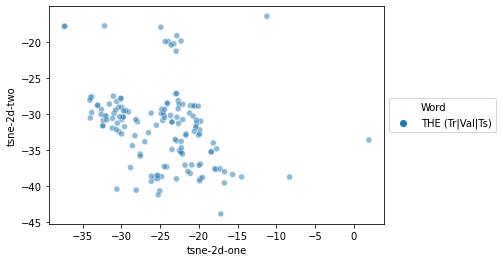

In [81]:
word_list = ["THE"]
visualize_words(word_list,tsne_vectors,labels)

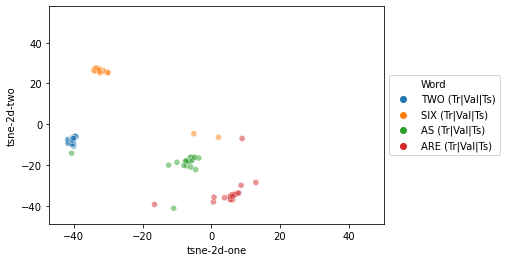

In [102]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels,True)

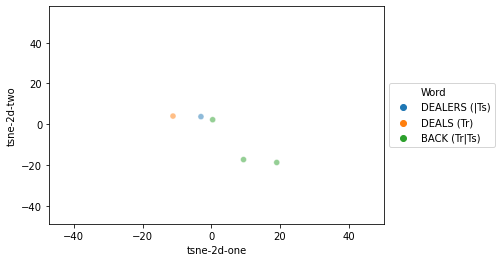

In [103]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

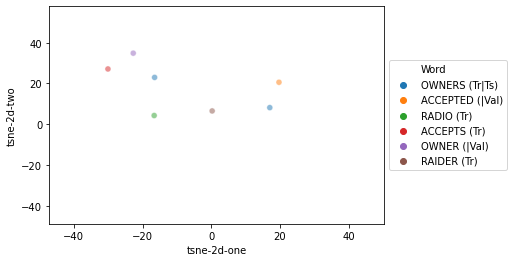

In [104]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

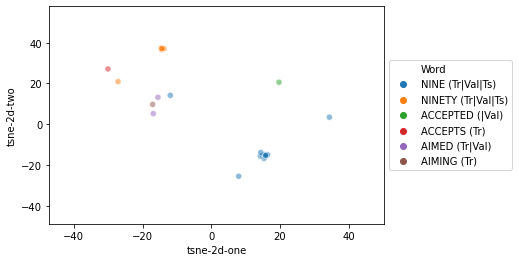

In [105]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

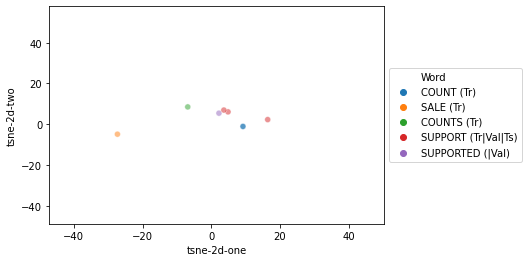

In [106]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

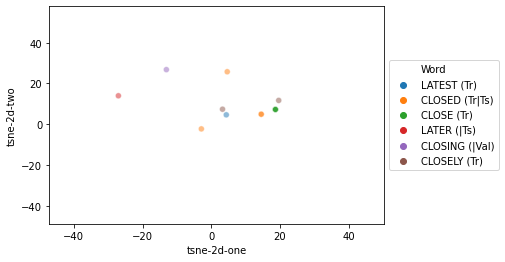

In [107]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [114]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [115]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

['SUPPORT', 'CLIMB', 'PROBABLY', 'AIRCRAFT', 'DIRECT']
['SUPPORT', 'OPERATOR', 'AIRCRAFT', 'HOLDING', 'SHARES']
['LIKELY', 'COMING', 'OPERATOR', 'SHARES', 'SURPRISE']


In [116]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

['LATER', 'UNDER', 'HUNDRED', 'UNDER', 'HUNDRED']


In [117]:
word = "CLOSING"
nearest_neighbors_for_word(word,indices,labels)

['CLOSING', 'WASHINGTON', 'AFTER', 'OPPOSITION', 'COMMENT']


In [118]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTED', 'INFLATION', 'PURCHASES', 'PROCESS', 'SPLIT']


In [119]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

['DEALS', 'PUBLICLY', 'FINANCIAL', 'FINANCIAL', 'EXPOSURE']


In [120]:
word = "ACCEPTS"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTS', 'SIX', 'BUSINESS', 'SIX', 'SINCE']


In [121]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

['DAY', 'MAY', 'MAY', 'MAY', 'EIGHT']
['DAY', 'BIDS', 'MAY', 'DAY', 'BASED']
['DAY', 'DAY', 'MAY', 'BIDS', 'BASED']
['DAY', 'YOU', 'HUNDRED', 'UNDER', 'CLEAR']


In [122]:
word = "DEALERS"
nearest_neighbors_for_word(word,indices,labels)

['DEALERS', 'LANGUAGE', 'GROUP', 'TOO', 'PREVIOUS']
